# EDA

In [2]:
from dataset import CustomNPZDataset, HFDataset, SSLDataset
from dataset import get_medmnist_transforms, plot_views, plot_ssl_views


import numpy as np

## Making sure dataset.py functions work

In [2]:
data_path = '../data/pneumoniamnist_224.npz'
size = 224

In [2]:
# For SSL

# Note: For SSL, we pass None as transform to base dataset because
# SSLDataset wrapper handles the transforms (generating 2 views).
# For Supervised, we pass the transform directly.
train_base = CustomNPZDataset(data_path, split='train', transform=None)
val_base = CustomNPZDataset(data_path, split='val', transform=None)
test_base = CustomNPZDataset(data_path, split='test', transform=None)

# Wrap with SSL dataset
transform = get_medmnist_transforms(size=size, augment=True)

train_set = SSLDataset(train_base, transform)
val_set = SSLDataset(val_base, transform)  # Usually SSL is only trained on train_set
test_set = SSLDataset(test_base, transform)

train_set = HFDataset(train_set, for_ssl=True)
val_set = HFDataset(val_set, for_ssl=True)
test_set = HFDataset(test_set, for_ssl=True)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
# print(f"Shapes: {train_set[0]['view1'].shape}, {train_set[0]['view2'].shape}")

Train: 4708, Val: 524, Test: 624


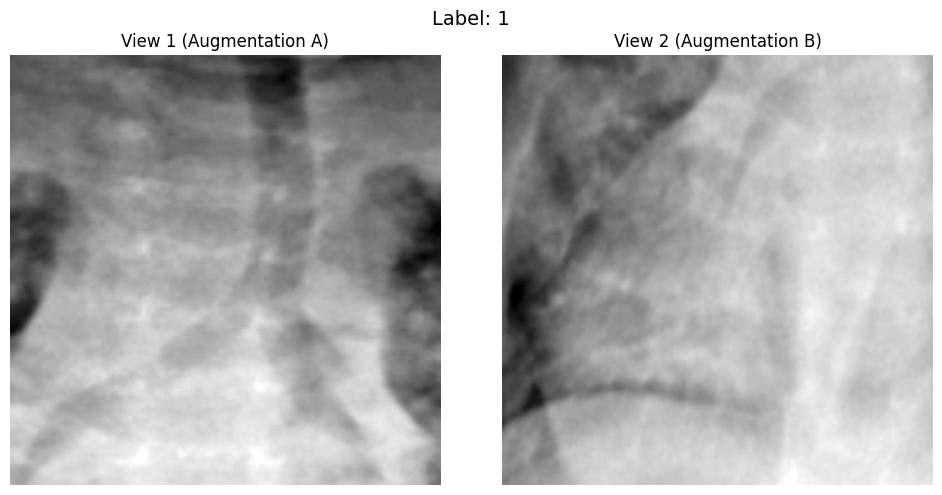

In [3]:
plot_ssl_views(train_set[np.random.randint(0, len(train_set))])

In [4]:
# For SFT
transform = get_medmnist_transforms(size=size, augment=False)

train_base = CustomNPZDataset(data_path, split='train', transform=transform)
val_base = CustomNPZDataset(data_path, split='val', transform=transform)
test_base = CustomNPZDataset(data_path, split='test', transform=transform)

train_set = HFDataset(train_base, for_ssl=False)
val_set = HFDataset(val_base, for_ssl=False)
test_set = HFDataset(test_base, for_ssl=False)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 4708, Val: 524, Test: 624


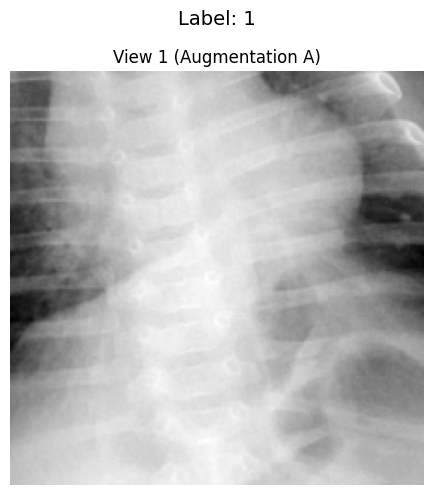

In [5]:
plot_views(train_set[np.random.randint(0, len(train_set))])

## pneumoniamnist

In [12]:
data_path = '../data/pneumoniamnist_224.npz'
size = 224

In [13]:
transform = get_medmnist_transforms(size=size, augment=False)

train_base = CustomNPZDataset(data_path, split='train', transform=transform)
val_base = CustomNPZDataset(data_path, split='val', transform=transform)
test_base = CustomNPZDataset(data_path, split='test', transform=transform)

train_set = HFDataset(train_base, for_ssl=False)
val_set = HFDataset(val_base, for_ssl=False)
test_set = HFDataset(test_base, for_ssl=False)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

Train: 4708, Val: 524, Test: 624


In [14]:
data = np.load('../data/pneumoniamnist_224.npz')
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])

print(f"Dataset size: {all_images.shape}")
print(f"Mean: {all_images.mean() / 255.0:.4f}") # Если данные 0-255
print(f"STD: {all_images.std() / 255.0:.4f}")
u = np.unique(np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']]), return_counts=True)
neg, pos = u[1]
print(f"Class balance:\n\tneg: {neg:,}\n\tpos: {pos:,}")

Dataset size: (5856, 224, 224)
Mean: 0.5706
STD: 0.1773
Class balance:
	neg: 1,583
	pos: 4,273


In [15]:
u

(array([0, 1], dtype=uint8), array([1583, 4273]))

## chestmnist

In [4]:
import numpy as np
from tqdm import tqdm

# This is written by Gemini 3, because my previous code was failing with:
# MemoryError: Unable to allocate 41.9 GiB for an array with shape (112120, 224, 224) and data type float64

def compute_stats_streaming(data_array, batch_size=256):
    """
    Вычисляет Mean и Std для большого массива, обрабатывая его батчами.
    Args:
        data_array: np.array или np.memmap формы (N, H, W) или (N, H, W, C)
    """
    mean = 0.0
    mean_sq = 0.0
    count = 0
    
    # Приводим к (N, -1), чтобы считать по всем пикселям сразу (если нужна статистика по каналам)
    # Или (N, H*W) если данные grayscale.
    # Если data_array в памяти, это просто view.
    
    num_samples = data_array.shape[0]
    
    for i in tqdm(range(0, num_samples, batch_size), desc="Computing stats"):
        # Берём батч
        batch = data_array[i : i + batch_size].astype(np.float32) / 255.0
        
        # Разворачиваем: (B, H, W) -> (B, H*W)
        batch_flat = batch.reshape(batch.shape[0], -1)
        
        # Накапливаем сумму и сумму квадратов
        # Важно взвешивать на размер батча, так как последний батч может быть меньше
        current_batch_size = batch_flat.size # общее число пикселей в батче
        
        mean += batch_flat.sum()
        mean_sq += (batch_flat ** 2).sum()
        count += current_batch_size

    total_mean = mean / count
    total_var = (mean_sq / count) - (total_mean ** 2)
    total_std = np.sqrt(total_var)
    
    return total_mean, total_std

In [3]:
data = np.load('../data/chestmnist_224.npz')
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']])

In [5]:
print(f"Dataset size: {all_images.shape}")
mean, std = compute_stats_streaming(all_images)

print(f"Mean: {mean:.4f}")
print(f"STD: {std:.4f}")

Dataset size: (112120, 224, 224)


Computing stats: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 438/438 [00:13<00:00, 33.26it/s]

Mean: 0.4981
STD: 0.2481


In [11]:
u = np.unique(np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']]), return_counts=True)
neg, pos = u[1]
# print(f"Class balance: {u}")
print(f"Class balance:\n\tneg: {neg:,}\n\tpos: {pos:,}")

Class balance: (array([0, 1], dtype=uint8), array([1488692,   80988]))
Class balance:
	neg: 1,488,692
	pos: 80,988


## Результаты

Для chestmnist у нас явно задача несбаллансированной классификации в обоих случаях. В качестве лосса просто возьмем BCE и навесим на меньший класс class weight множитель. В качестве метрики в обоих случаях возьмем PR-AUC. Также можно будет дополнительно померять F-beta score для какого-то порога, так как мы работаем с медицинскими данными, хотелось бы значимость рекола выкуртить и брать F2/F3 score.